In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [8]:
class ForthAgentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,32,9,1,3) # 15 x 15 x 32
        self.linear1 = nn.Linear(7200,7200)
        self.linear2 = nn.Linear(7200,1024)
        self.linear3= nn.Linear(1024,6)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.reshape(-1,7200)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [9]:
import torch.optim as optim
model = ForthAgentModel()
print(sum(p.numel() for p in model.parameters()))
device = "cpu"
model.to(device)
print(list(model.parameters()))
feat = torch.rand((1,5,17,17),dtype=torch.float32,device=device)

59240166
[Parameter containing:
tensor([[[[ 4.1778e-02,  1.3049e-02, -1.3310e-02,  ..., -4.5893e-02,
            4.7095e-02, -2.1182e-02],
          [-2.1490e-03,  4.2690e-02,  4.8187e-02,  ..., -4.4465e-03,
           -2.2765e-03, -2.5443e-02],
          [ 6.0019e-03, -1.8102e-02,  2.7744e-02,  ...,  4.1875e-02,
            3.9311e-02,  4.4707e-02],
          ...,
          [ 1.0845e-02,  2.2307e-02,  2.8832e-03,  ...,  4.7755e-02,
            5.4323e-04,  2.0887e-02],
          [ 3.0585e-02, -2.3166e-02,  6.7147e-03,  ..., -8.2225e-03,
            1.6066e-02,  4.5255e-02],
          [-1.8104e-02, -4.5032e-02,  1.2208e-02,  ...,  1.2764e-02,
           -4.0594e-02,  2.3506e-04]],

         [[-3.2607e-02, -2.8069e-02, -4.1137e-02,  ...,  1.8418e-03,
           -3.7653e-02,  8.1310e-03],
          [ 1.5066e-02, -3.6664e-02,  3.3113e-02,  ..., -2.1767e-02,
            1.0334e-02, -4.7515e-02],
          [ 3.5411e-02, -4.0910e-02,  2.8679e-02,  ...,  3.6603e-02,
           -1.5826e-02,  1

In [10]:
%%timeit
res = model.forward(feat)
#torch.cuda.synchronize()
#print(res)


8.61 ms ± 356 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


cuda:
res = model.forward(torch.rand((100,4,17,17),dtype=torch.float32,device=device))
1.28 ms ± 14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1000:
9.05 ms ± 39.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10k:
87.7 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
cpu:
27.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1000:
235 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10k:
2.39 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [11]:
torch.save(model.state_dict(),"model.pth")

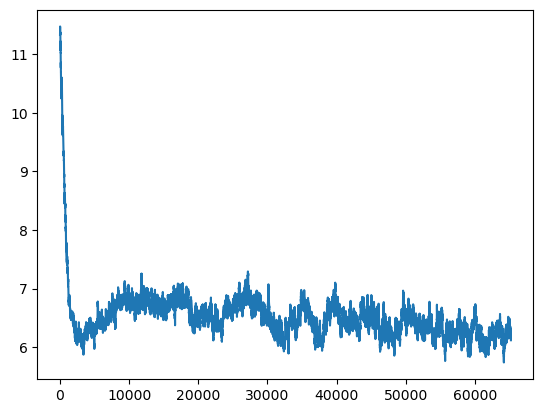

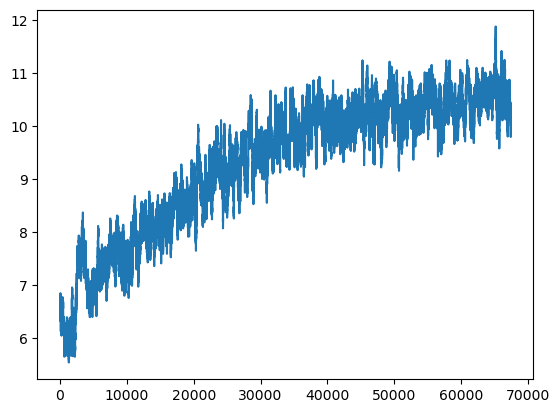

In [4]:
# analyze the loss
# https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot
from typing import List


def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

import matplotlib.pyplot as plt
import numpy as np
loss = np.load("./2024.09.16-03.30.51/2024.09.16-03.30.51_loss_history.npy")
plt.figure()
#plt.yscale("log")
plt.plot(smooth(loss,0.99))
plt.show()
loss = np.load("./2024.09.16-03.30.51/2024.09.16-03.30.51_score_history.npy")
plt.figure()
#plt.yscale("log")
plt.plot(smooth(loss,0.99)[600:])

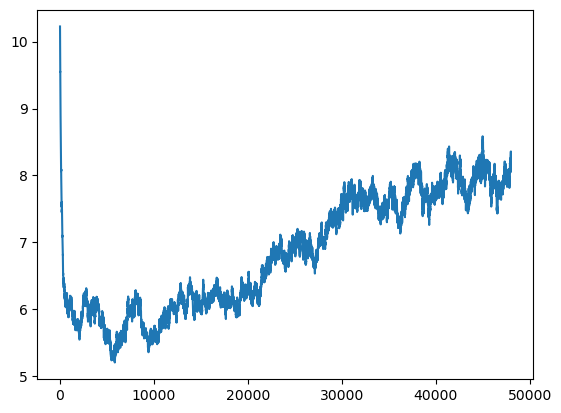

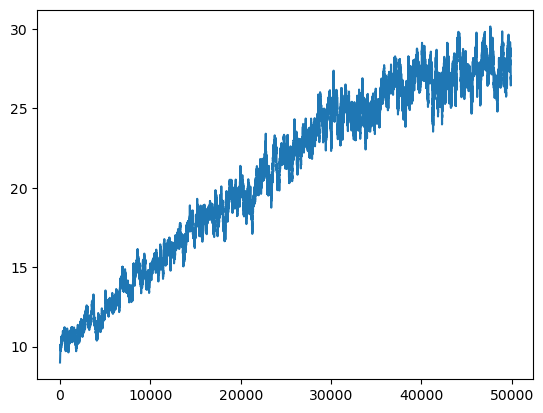

In [1]:

# analyze the loss
# https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot
from typing import List


def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

import matplotlib.pyplot as plt
import numpy as np
loss = np.load("2024.09.18-04.33.13_loss_history.npy")
plt.figure()
#plt.yscale("log")
plt.plot(smooth(loss,0.99))
plt.show() # old

loss = np.load("2024.09.18-04.33.13_score_history.npy")
plt.figure()
#plt.yscale("log")
plt.plot(smooth(loss,0.99))
plt.show() # old

In [ ]:
class SecondAgentModel(nn.Module):
    active_indices: np.ndarray[int]

    def __init__(self, input_size, output_size: int = 6, p1=0.3, p2=0.3, p_lin=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(4,64,5,1,"same") # 17x17
        self.pool1 = nn.MaxPool2d(2,2,1) # 8x8
        self.conv2 = nn.Conv2d(64,128,3,1,0) # # 6x6
        self.pool2 = nn.MaxPool2d(2,2,0)  
        self.drop_layer1 = nn.Dropout(p=p1)
        self.drop_layer2 = nn.Dropout(p=p2)
        self.drop_layer_lin = nn.Dropout(p=p_lin)
        self.linear1 = nn.Linear(1152,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,256)
        self.linear4 = nn.Linear(256,128)
        self.linear5 = nn.Linear(128,64)
        self.linear6 = nn.Linear(64,32)
        self.linear7 = nn.Linear(32,16)
        self.linear8= nn.Linear(16,6)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x= self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        print(x.shape)
        x = x.reshape(-1,1152)
        x = (F.relu(self.linear1(x)))
        x = (F.relu(self.linear2(x)))
        x = (F.relu(self.linear3(x)))
        x = (F.relu(self.linear4(x)))
        x = (F.relu(self.linear5(x)))
        x = (F.relu(self.linear6(x)))
        x = (F.relu(self.linear7(x)))
        x = self.linear8(x)
        return x


In [44]:
def state_to_features_4(game_state: dict | None = None) -> tuple[np.array,bool,bool,bool]:
    """
    *This is not a required function, but an idea to structure your code.*

    Converts the game state to the input of your model, i.e.
    a feature vector.

    You can find out about the state of the game environment via game_state,
    which is a dictionary. Consult 'get_state_for_agent' in environment.py to see
    what it contains.

    :param game_state:  A dictionary describing the current game board.

    :return: np.array (length: 176 *2 + 12 + 8 = 372)
    """
    if game_state is None:
        return None
    x, y = game_state["self"][3]
    transpose=False
    x_flip = False
    y_flip = False

    flip_dims = []
    result = np.zeros((5,17,17),dtype=np.float32)
    for xybomb in game_state["bombs"]:
        # tuple unpacking
        xy, bomb_timer = xybomb
        result[2][xy] = bomb_timer + 1.

    #coins = np.zeros((17, 17),dtype=np.float32)
    for coin_cords in game_state["coins"]:
        result[3][coin_cords] = 1.

    result[4][game_state["self"][3]] = 4 + 1 * game_state["self"][2] # actually use the value

    # it does not matter if the agents are in different orders for each step,
    # as we do not distinguish between them.
    for agent in game_state["others"]:
        result[4][agent[3]] = -4   - (1* agent[2])
    #now apply flips:
    if x > 8:
        flip_dims.append(0)
        x_flip = True
        x = 16 - x
    if y > 8:
        flip_dims.append(1)
        y_flip = True
        y = 16 - y
    if y > x:
        transpose = True
        result[0]=np.flip(game_state["field"],flip_dims).transpose()
        result[1]=np.flip(game_state["explosion_map"],flip_dims).transpose()
        result[2]=np.flip(result[2],flip_dims).transpose()
        result[3]=np.flip(result[3],flip_dims).transpose()
        result[4]=np.flip(result[4],flip_dims).transpose()
    else:
        result[0]=np.flip(game_state["field"],flip_dims)
        result[1]=np.flip(game_state["explosion_map"],flip_dims)
        result[2]=np.flip(result[2],flip_dims)
        result[3]=np.flip(result[3],flip_dims)
        result[4]=np.flip(result[4],flip_dims)

    stacked_channels = torch.from_numpy(result).to(dtype=torch.float32, device=device)
    return (stacked_channels,x_flip,y_flip,transpose)

In [10]:
def state_to_features_3(game_state: dict | None = None) -> tuple[np.array,bool,bool,bool]:
    """
    *This is not a required function, but an idea to structure your code.*

    Converts the game state to the input of your model, i.e.
    a feature vector.

    You can find out about the state of the game environment via game_state,
    which is a dictionary. Consult 'get_state_for_agent' in environment.py to see
    what it contains.

    :param game_state:  A dictionary describing the current game board.

    :return: np.array (length: 176 *2 + 12 + 8 = 372)
    """

    # mutate the state so that the agent will always have x,y <= 8, (is in the top left corner)
    # TODO: in the future, maybe aditionally ensure that x>=y, to exploit even more symetry.

    x, y = game_state["self"][3]
    transpose=False
    x_flip = False
    y_flip = False
    # these values get checked later

    # This is the dict before the game begins and after it ends
    if game_state is None:
        return None

    # For example, you could construct several channels of equal shape, ...

    # field and explosion are numpy, others are torch
    field: np.ndarray = game_state["field"]  # TODO: check if modifying this is allowed or copy is needed
    coins = torch.full((17, 17), 0)
    for coin_cords in game_state["coins"]:
        coins[coin_cords] = 1

    explosion_copy: np.ndarray = game_state["explosion_map"]

    bombs = torch.full((17, 17), 0)
    for xybomb in game_state["bombs"]:
        # tuple unpacking
        xy, bomb_timer = xybomb
        bombs[xy] = bomb_timer + 1

    # now pass position of each agent (we, enemy 1, 2,3)
    #agent_positions = torch.full((17, 17), 0)
    # our agent:
    # 5 if can place a bomb, 1 if not
    our_agent_encode = 3+ 2 * game_state["self"][2] # 1 if bomb not possible, 5 if possible
    field[game_state["self"][3]] = our_agent_encode # actually use the value

    # it does not matter if the agents are in different orders for each step,
    # as we do not distinguish between them.
    for agent in game_state["others"]:
        field[agent[3]] = -3   - (2 * agent[2])

    #now apply flips:
    if x > 8:
        x_flip = True
        x = 16 - x
        field = np.flipud(field)
        explosion_copy = np.flipud(explosion_copy)
        coins= torch.flipud(coins)
        bombs=torch.flipud(bombs)

    if y > 8:
        y_flip = True
        y = 16 - y
        field = np.fliplr(field)
        explosion_copy = np.fliplr(explosion_copy)
        coins = torch.fliplr(coins)
        bombs = torch.fliplr(bombs)
    
    if y > x:
        transpose = True
        field = field.T
        explosion_copy = explosion_copy.T
        coins = coins.T
        bombs = bombs.T

    channels = [
        torch.tensor(field.copy(), dtype=torch.float32), # contains, walls, crates, spaces, players
        coins,
        torch.tensor(explosion_copy.copy()),
        bombs,
    ]

    # concatenate them as a feature tensor (they must have the same shape), ...
    stacked_channels = torch.stack(channels).to(dtype=torch.float32, device=device)
    # and return them as a vector
    return (stacked_channels,x_flip,y_flip,transpose)


In [35]:
gs = {
    "round": 1,
    "step": 7,
    "field": np.array(
        [
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, -1],
            [-1, 0, -1, 1, -1, 1, -1, 1, -1, 0, -1, 1, -1, 1, -1, 0, -1],
            [-1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, -1],
            [-1, 1, -1, 1, -1, 0, -1, 0, -1, 1, -1, 0, -1, 0, -1, 1, -1],
            [-1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, -1],
            [-1, 1, -1, 1, -1, 1, -1, 1, -1, 0, -1, 1, -1, 0, -1, 1, -1],
            [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, -1],
            [-1, 1, -1, 1, -1, 1, -1, 0, -1, 1, -1, 0, -1, 0, -1, 0, -1],
            [-1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, -1],
            [-1, 1, -1, 1, -1, 1, -1, 0, -1, 1, -1, 1, -1, 1, -1, 1, -1],
            [-1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, -1],
            [-1, 0, -1, 0, -1, 0, -1, 1, -1, 1, -1, 1, -1, 1, -1, 0, -1],
            [-1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, -1],
            [-1, 0, -1, 1, -1, 1, -1, 1, -1, 0, -1, 1, -1, 1, -1, 0, -1],
            [-1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        ]
    ),
    "self": ("rule_based_agent_0", 0, False, (2, 15)),
    "others": [
        ("rule_based_agent_1", 0, False, (2, 1)),
        ("rule_based_agent_2", 0, False, (15, 4)),
        ("rule_based_agent_3", 0, False, (15, 14)),
    ],
    "bombs": [((1, 3), 0)],
    "coins": [(3,4)], # this is an edit, idk if possible
    "user_input": None,
    "explosion_map": np.array(
        [
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        ]
    ),
}


In [39]:
%%timeit
feat = state_to_features_3(gs)

79.1 μs ± 495 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit
feat = state_to_features_4(gs)

53.4 μs ± 2.1 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
%%timeit
feat = state_to_features_4(gs)

55.1 μs ± 773 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
